# Network embedding

Generally speaking, an **embedding** refers to some technique which takes a network (or
networks as we'll see later) and converts it to a representation in some vector space.
Often, this is a Euclidean vector space, and in that space each vector represents a
single node in the network. We'll focus on this case for now.

## Why embed networks? 
- Embedding networks can be viewed as fitting the parameters of statistical models, 
  for example, a random dot product graph.
- Embeddings can be useful for creating visualizations of networks. 
- Embeddings allow us to use a wide range of general machine learning techniques and
  make them applicable for networks.

## Spectral methods

A few classes ago when we discussed [random network models](random_graphs.ipynb), we
talked about how there was a method for estimating the parameters of the random dot product graph (RDPG) model. For simplicity, lets consider an undirected version of this model. Recall
what this means - the model is that the adjacency matrix $A$ is sampled from a probability
matrix $P$, and that this $P$ matrix is *low rank*. In other words, it can be written as

$$P = X X^T$$

for some matrix, $X$, which we'll call the **latent position matrix**. $X$ is an $n \times d$
matrix, where $d$ is the dimension of our model or the length of the latent position
vector of each node.

In practice, we never observe $X$ - we observe the adjacency matrix $X$, and wish to 
estimate $X$ from it. 

### Low-rank approximation

One fundamental concept in statistics and machine learning is that of a [**low-rank 
decomposition**](https://en.wikipedia.org/wiki/Low-rank_approximation). In general, 
this means approximating some data matrix with a less complex while still preserving certain properties of the data. One fundamental tool in this field is the [**singular value 
decomposition (SVD)**](https://en.wikipedia.org/wiki/Singular_value_decomposition). If
you aren't familiar with the SVD, I *highly* recommend learning more about it, as it is
one of the most important mathematical tools in science and engineering. I'll briefly 
state what it is here.

### Singular value decomposition
Let $M$ be some $m \times n$ real matrix with rank $r$. Then, this matrix can be 
factorized as

$$M = U \Sigma V^T$$

where these matrices have the following properties: 
- $U$ is $m \times r$ with orthonormal columns (i.e. $U^T U = I_{r}$, the $r \times r$ identity)
- $V$ is $n \times r$ with orthonormal columns (i.e. $V^T V = I_{r}$)
- $\Sigma$ is $r \times r$ and diagonal, with elements on the diagonal in decreasing order

The factorization above is called the singular value decomposition.

What do we call these different pieces of the decomposition?
- The columns of $U$ are called the **left singular vectors**. 
- The columns of $V$ are called the **right singular vectors**.
- The elements on the diagonal of $\Sigma$ are called the **singular values**.

```{note}
If $M$ is square and symmetric (e.g. the adjacency matrix for an undirected graph), note
that the left and the right singular vectors are the same, so we could write

$$M = U \Sigma U^T$$

More commonly, it will be written as 

$$M = U D U^T$$

This is also known as an **eigendecomposition**. For this reason, you may see people use 
these terms interchangably, in particular for undirected networks.
```

### Eckart-Young-Mirsky theorem
Why did we go to all of this trouble to decompose our matrix in this way? There are a 
TON of different ways to see the value of the SVD - some are geometric, some are 
statistical, and many more. Here we'll consider one of these perspectives, which is that
of the low-rank decomposition described above.

Let's say I hand you a matrix, $A$, which is some square real data matrix I observed (it doesn't actually have to be square for the theorem to hold, though). 
In almost all cases, this matrix is going to be of full rank - it will have as many 
nonzero singular values as it has dimensions. Then I ask you to approximate this matrix,
using another matrix, $A_d$, which has rank at most $d$. I am going to measure how well
you approximate my matrix $A$ in the following way: 

$$e = \|A - A_d\|_F$$

where $\| \cdot \|_F$ is the matrix [**Frobenius norm**](https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm). The Frobenius norm is like the $l_2$ or Euclidean norm for 
vectors, but applied to a matrix. I simply sum up the squared values in the matrix, and 
then take the square root of that sum.

What the [Eckart-Young-Mirsky theorem](https://en.wikipedia.org/wiki/Low-rank_approximation#Proof_of_Eckart%E2%80%93Young%E2%80%93Mirsky_theorem_(for_Frobenius_norm)) says is that the best solution to the problem I posed above (i.e. the $A_d$
which minimizes $e$) is given by:

$$A_d = U_d \Sigma_d V_d^T$$

where $U_d$ is the matrix with only the first $d$ left singular vectors of $A$, $V_d$ is
defined likewise for the right singular vectors, and $\Sigma_d$ is a $d \times d$ matrix
with only the first $d$ singular values on the diagonal. The decomposition in for $A_d$ 
above would be called a **truncated singular value decomposition** of $A$.

### Adjacency Spectral Embedding
Great, now lets turn back to our specific case of networks. Given everything we just 
discussed, you may see where we're headed. 

Now, if I ask you to do a low-rank approximation of the adjacency matrix $A$ of a network, you know what
to do (at least, if we care about the Frobenius norm of the difference).

For an undirected network, we'd have

$$A_d = U_d \Sigma_d U_d^T$$

we can absorb the singular values into the vectors themselves

$$X = U_d \Sigma_d^{1/2}$$

so that 

$$A_d =  U_d \Sigma_d U_d^T = U_d \Sigma_d^{1/2} \Sigma_d^{1/2} U_d^T = U_d \Sigma_d^{1/2} (U_d \Sigma_d^{1/2})^T = X X^T$$

For a directed network, we can do something similar

$$A_d = U_d \Sigma_d V_d^T = X Y^T$$

where $X$ has the same meaning as before, and $Y$ is defined likewise for $V$.

Does this formula remind you of anything? It looks awfully similar to the formula for
the RDPG: $P = X Y^T$. It turns out that this process, which is called the 
**adjacency spectral embedding (ASE)**, is a consistent estimator for the parameters $X$ and $Y$ 
in the RDPG setting. What "consistent" means in this setting is that is we had a network
generated from an RDPG, and then let the number of nodes in the network grow to infinity,
then the $\hat{X}$ matrix we estimate via ASE would converge to the true latent position
matrix, $X$.

Let's see what this looks like in terms of implementation.

In [33]:
import numpy as np
from graspologic.datasets import load_drosophila_right
from graspologic.utils import binarize

A, labels = load_drosophila_right(return_labels=True)
A_bin = binarize(A)

U, S, Vt = np.linalg.svd(A_bin)

d = 3
sigma_root = np.diag(np.sqrt(S[:d]))

X = U[:, :d] @ sigma_root
Y = Vt.T[:, :d] @ sigma_root

Pretty simple! We can use these estimates to reconstruct an estimate of the probability
matrix if we wanted to model the network as an RDPG.

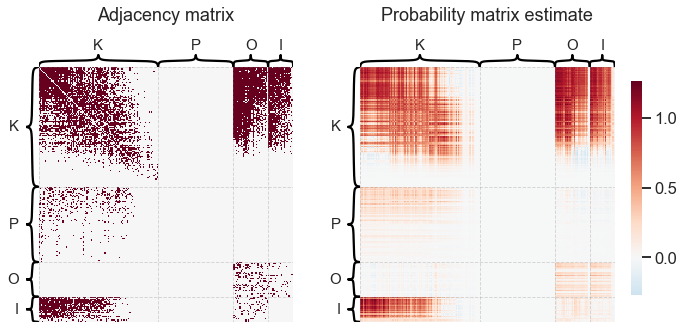

In [34]:
import matplotlib.pyplot as plt
from graspologic.plot import heatmap

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
heatmap(
    A_bin,
    ax=ax,
    inner_hier_labels=labels,
    title="Adjacency matrix",
    hier_label_fontsize=15,
)
fig.axes[2].remove()

ax = axs[1]
heatmap(
    X @ Y.T,
    ax=ax,
    inner_hier_labels=labels,
    title="Probability matrix estimate",
    hier_label_fontsize=15,
)

plt.tight_layout()

In `graspologic`, this functionality is implemented under the `AdjacencySpectralEmbed` 
estimator class. There are a few extra bells and whistles, but the core algorithm is
exactly the same as the one above - just an SVD of the adjacency matrix. Note that this
algorithm also works well for weighted networks, but we lose some of the interpretation
of the approximation matrix as a matrix of probabilities.

In [35]:
from graspologic.embed import AdjacencySpectralEmbed

ase = AdjacencySpectralEmbed()

X, Y = ase.fit_transform(A)

```{note}
`ase.fit_transform()` returns a tuple `(X, Y)` if the graph is directed. Otherwise, it
just returns `X`.
```

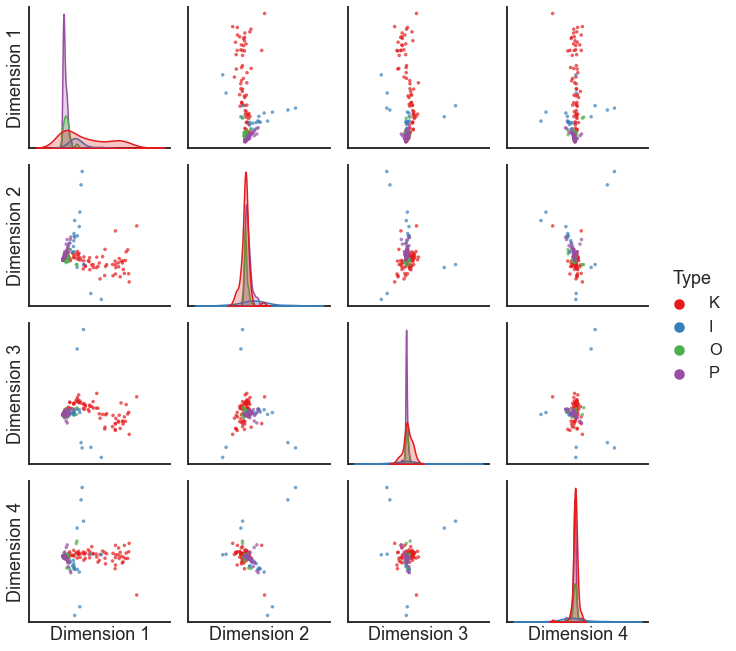

In [36]:
from graspologic.plot import pairplot

pairplot(X, labels=labels)

This is a perfectly fine ASE - but note that the embedding above is somewhat dominated
by a few nodes. 

```{admonition} Question
:class: tip
What do you think is special about the nodes which are most salient in the plot above?
```

The edge weights in this dataset cover a few orders of magnitude - there are a small
number of edges which have very high weights.

[Text(0.5, 0, 'Edge weight')]

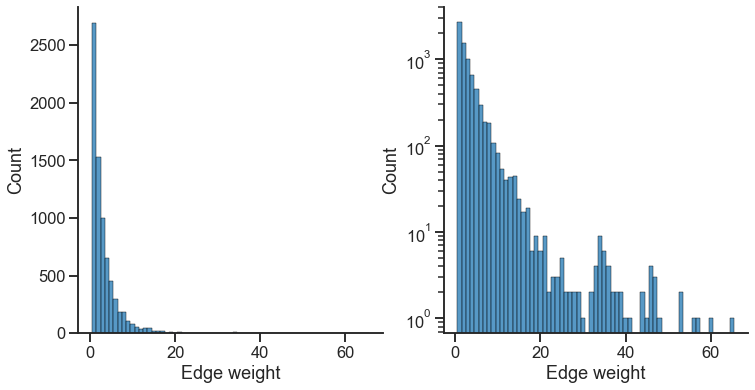

In [37]:
import seaborn as sns
sns.set_context('talk')

row_indices, col_indices = np.nonzero(A)  # gives me the location of each edge

edges = A[row_indices, col_indices]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
ax = axs[0]
sns.histplot(x=edges, discrete=True, ax=ax)
ax.spines[["right", "top"]].set_visible(False)
ax.set(xlabel="Edge weight")

ax = axs[1]
sns.histplot(x=edges, discrete=True, ax=ax)
ax.set_yscale("log")
ax.spines[["right", "top"]].set_visible(False)
ax.set(xlabel="Edge weight")

For spectral methods on weighted networks, we often find it useful to do an operation 
called "pass-to-ranks." This essentially ranks each edge from smallest to largest weight,
then replaces the edge weight by a normalized version of the rank. It has the effect of
putting edges closer to the same scale.

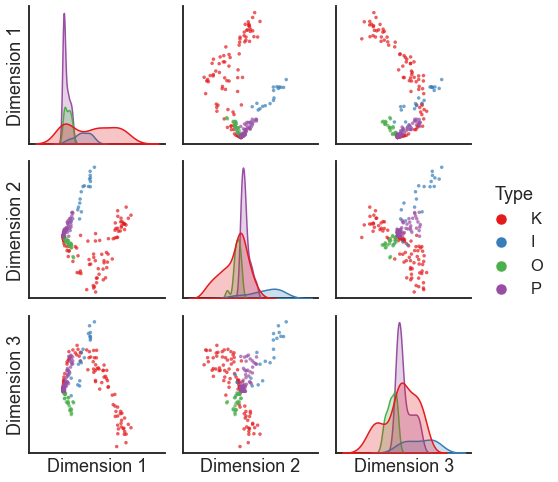

In [38]:
from graspologic.utils import pass_to_ranks

ase = AdjacencySpectralEmbed()

A_ptr = pass_to_ranks(A)

X, Y = ase.fit_transform(A_ptr)

pairplot(X, labels=labels)

For some applications, we don't care about having a separate representation for each 
node in terms of its inputs and outputs. We can simply concatenate the "out" and "in" 
representations.

In [39]:
Z = np.concatenate((X, Y), axis=1)
Z.shape

(213, 6)

Or, we can specify this behavior in `graspologic`.

In [40]:
Z = AdjacencySpectralEmbed(concat=True).fit_transform(A_ptr)
Z.shape

(213, 6)

### Laplacian spectral embedding

Thus far, we've motivated our spectral approaches by talking about random dot product
graphs and matrix approximation. However, there's a parallel way to arrive at some of
these ideas, in particular for a related algorithm called **laplacian spectral embeddding (LSE)**. This is the workhorse behind an old and popular method called [spectral clustering](https://en.wikipedia.org/wiki/Spectral_clustering).

Let's consider an undirected network, with degree vector $k$. Let $D$ be a diagonal
matrix with $k$ on its diagonal. One version of the
Laplacian $L$ (there are many) which is often called the unnormalized Laplacian, is just

$$L = D - A$$

There is a TON of cool math surrounding these methods that we could talk about - for 
instance, looking at the eigenvectors of the Laplacian matrix can perform a kind of 
"spring layout" of the network, where each edge is treated as a spring, and the goal
is to arrange nodes to minimize the energy of this system. Another perspective is that eigenvectors of the Laplacian give an approximate solution to the [min-cut problem](https://en.wikipedia.org/wiki/Minimum_cut). If you are curious about the Laplacian and any of these perspectives, I 
highly recommend looking at {cite:t}`von2007tutorial`.

Briefly, I'll just say that for a graph with multiple connected components, the
eigenvectors of the Laplacian turn out to be indicator functions for each of these 
connected components. Let's look at the eigenvectors for a graph with three connected
components.

[Text(0, 0.5, 'Eigenvector element')]

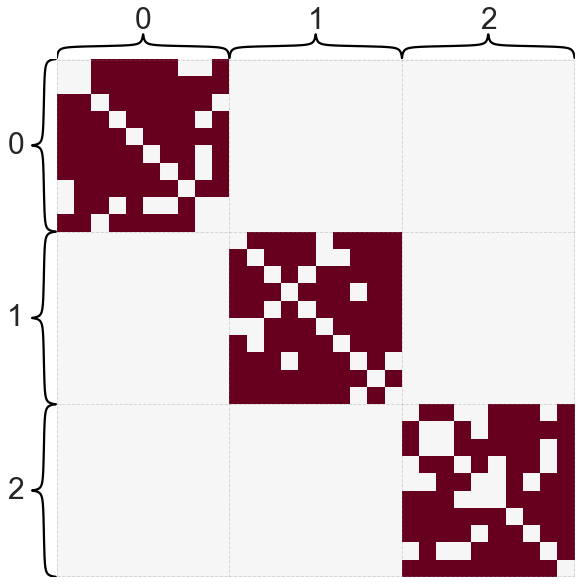

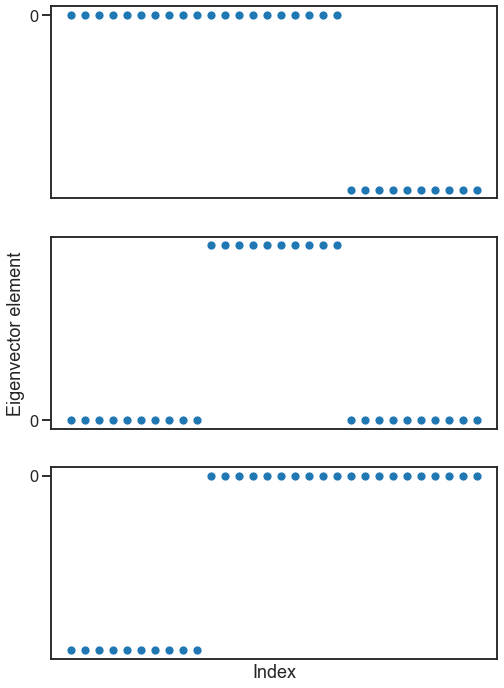

In [41]:
import pandas as pd
from graspologic.simulations import sbm


def eig(A):
    evals, evecs = np.linalg.eig(A)
    sort_inds = np.argsort(evals)
    evals = evals[sort_inds]
    evecs = evecs[:, sort_inds]
    return evals, evecs


B = np.array([[0.8, 0, 0], [0, 0.8, 0], [0, 0, 0.8]])
A, labels = sbm([10, 10, 10], B, return_labels=True)
heatmap(A, cbar=False, inner_hier_labels=labels)
degrees = np.sum(A, axis=0)
D = np.diag(degrees)
L = D - A
evals, evecs = eig(L)

fig, axs = plt.subplots(3, 1, figsize=(8, 12))
for i in range(3):
    ax = axs[i]
    sns.scatterplot(y=evecs[:, i], x=np.arange(len(evecs[:, i])), ax=ax)
    ax.set(xticks=[], yticks=[0])
axs[-1].set(xlabel=("Index"))
axs[1].set(ylabel=("Eigenvector element"))

What if the graph doesn't have multiple connected components, but has a *fuzzy* version
of this - i.e. some parts of the graph that are mostly disconnected from the rest?

[Text(0, 0.5, 'Eigenvector element')]

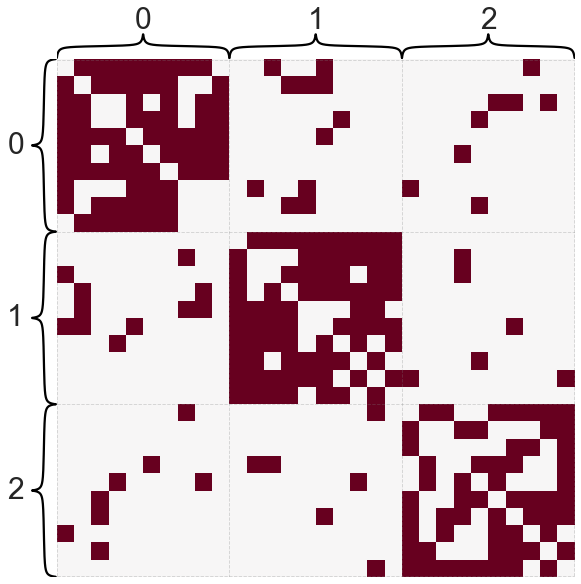

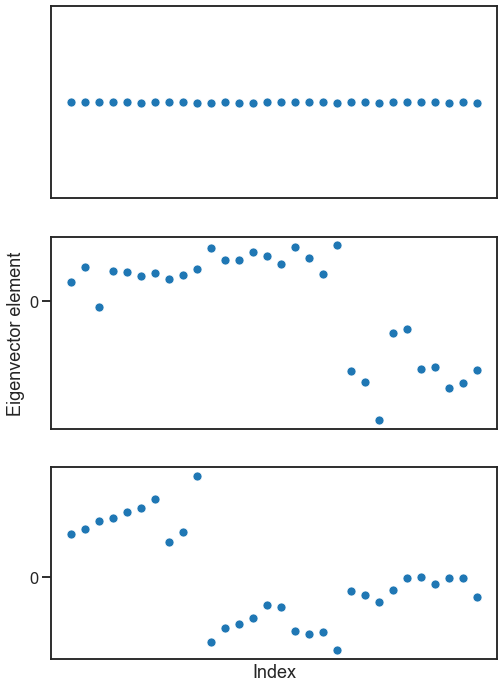

In [42]:
B = np.array([[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]])
A, labels = sbm([10, 10, 10], B, return_labels=True)
heatmap(A, cbar=False, inner_hier_labels=labels)
degrees = np.sum(A, axis=0)
D = np.diag(degrees)
L = D - A
evals, evecs = eig(L)

fig, axs = plt.subplots(3, 1, figsize=(8, 12))
for i in range(3):
    ax = axs[i]
    sns.scatterplot(y=evecs[:, i], x=np.arange(len(evecs[:, i])), ax=ax)
    ax.set(xticks=[], yticks=[0])
axs[-1].set(xlabel=("Index"))
axs[1].set(ylabel=("Eigenvector element"))

```{admonition} Question
Why does the first eigenvector look like it does, where all nodes seem to be equal?
```

Hopefully you can see why this kind of analysis could be useful, and might relate to 
the idea of spectral clustering I mentioned before. By analyzing the eigendecomposition
of the Laplacian (say, by clustering it), often we can understand meaningful partitions
of a network. 

Let's look at how this type of analysis looks on the C. elegans connectome from 
{cite:t}`cook2019whole`.

```{figure} ./images/c-elegans.png

Network diagram and 3D position of neurons in the C. elegans male connectome. Figure
from {cite:t}`cook2019whole`.
```

[Text(0.5, 0, 'Index (node)'), Text(0, 0.5, 'Value in eigenvector')]

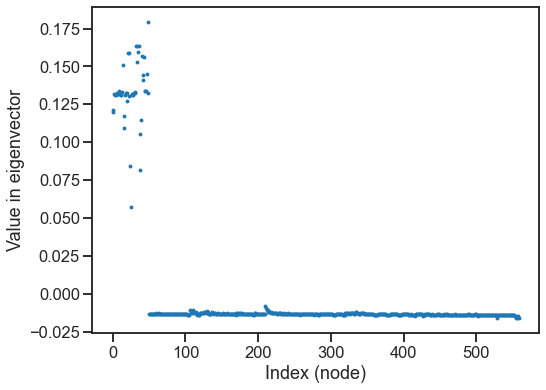

In [43]:
data_path = "networks-course/data/celegans/male_chem_A_self_undirected.csv"
meta_path = "networks-course/data/celegans/master_cells.csv"
cells_path = "networks-course/data/celegans/male_chem_self_cells.csv"
adj = pd.read_csv(data_path, header=None)
meta = pd.read_csv(meta_path, header=None, index_col=0)
cells = np.squeeze(pd.read_csv(cells_path, header=None).values)
meta = meta.reindex(cells)
A = adj.values

degrees = np.sum(A, axis=0)
D = np.diag(degrees)
L = D - A
evals, evecs = eig(L)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(y=evecs[:, 1], x=np.arange(len(evecs[:, 1])), ax=ax, linewidth=0, s=15)
ax.set(xlabel="Index (node)", ylabel="Value in eigenvector")

```{admonition} Question 
:class: tip

What do you think is different or special about the nodes that are well represented
in this eigenvector?
```

<AxesSubplot:>

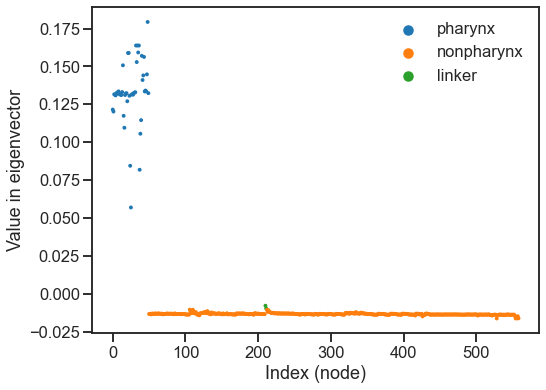

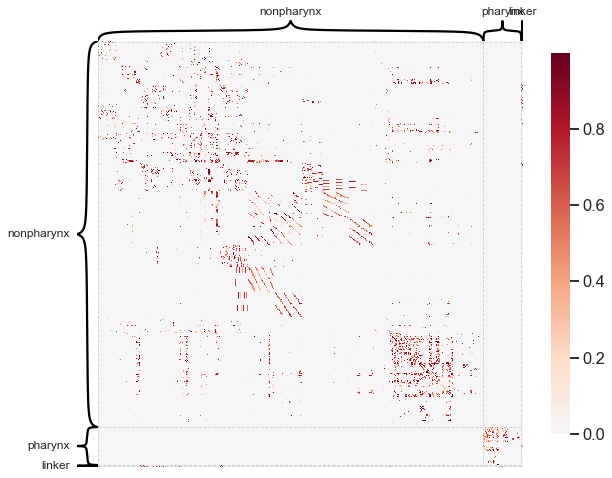

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
hue = meta[6].values
sns.scatterplot(
    y=evecs[:, 1], x=np.arange(len(evecs[:, 1])), hue=hue, ax=ax, linewidth=0, s=15
)
ax.set(xlabel="Index (node)", ylabel="Value in eigenvector")

#%%
# janky code to look at the adjacency matrix sorted this way.
# not sure why there is a nan
is_pharynx = list(meta[6].values)
for i, val in enumerate(is_pharynx):
    if val not in ["pharynx", "nonpharynx", "linker"]:
        is_pharynx[i] = "nonpharynx"
heatmap(
    A, inner_hier_labels=is_pharynx, transform="simple-nonzero", hier_label_fontsize=12
)

In practice, we often use LSE much like ASE. We can use the implementation in
`graspologic`, which is very similar to the above but uses a slightly different version
of the Laplacian. I always recommend using the *regularized* version of the Laplacian,
which does a better job of dealing with nodes with highly varying degrees.
Again, I recommend trying the the pass-to-ranks method if working on a weighted network.

In [45]:
from graspologic.embed import LaplacianSpectralEmbed

lse = LaplacianSpectralEmbed(n_components=5, form="R-DAD")

X = lse.fit_transform(pass_to_ranks(A))

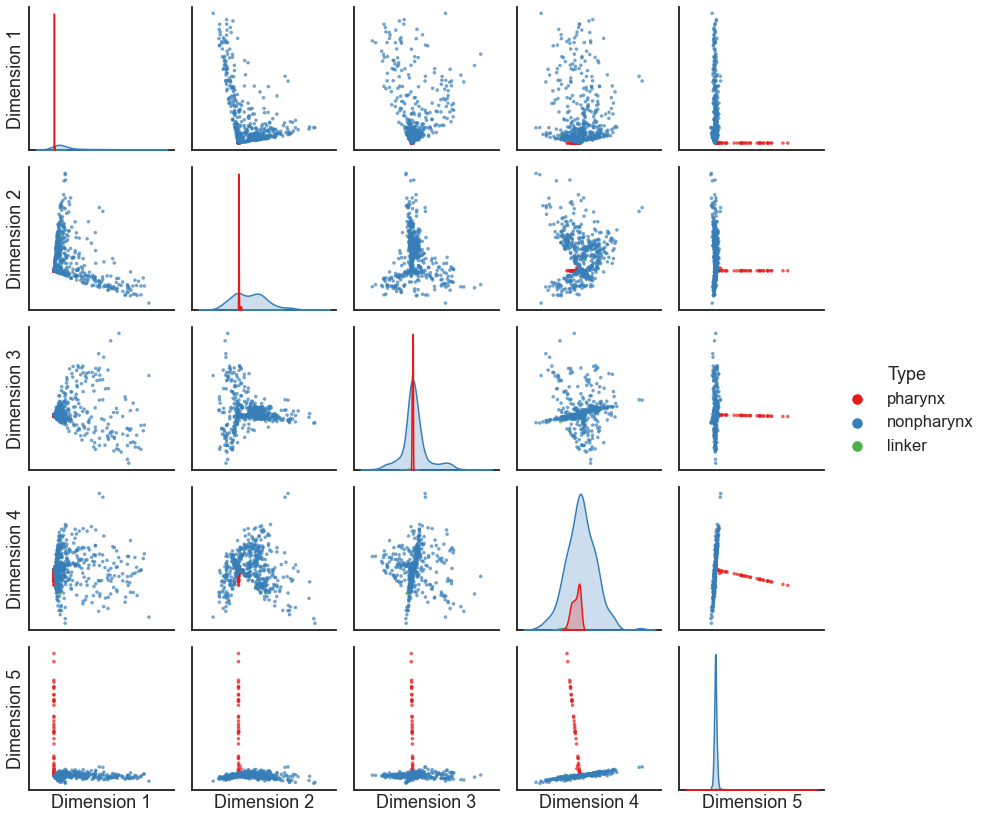

In [46]:
pairplot(X, labels=is_pharynx)

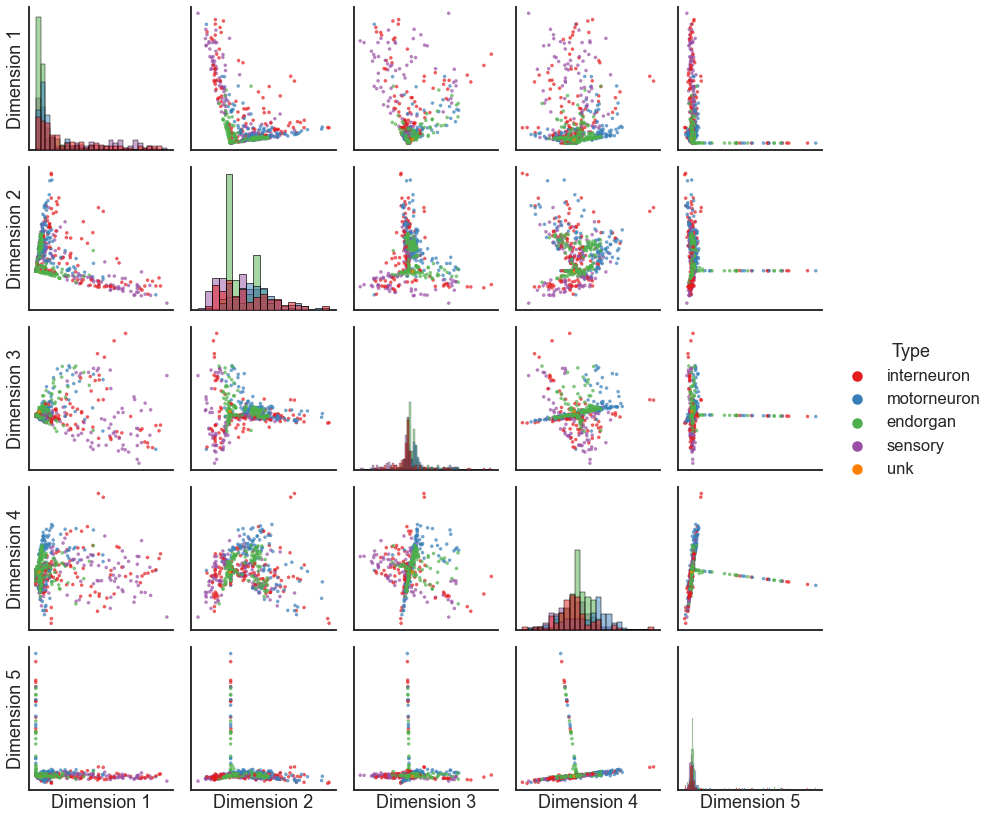

In [47]:
pairplot(X, labels=meta[1].fillna("unk").values)

```{admonition} Question 
:class: tip

Notice the "spokes" or dense lines in this plot - what might those represent?
```

### Two truths

So, why use LSE or ASE over the other? This is a good illustration of one important 
point about network embeddings - usually, one method isn't necessarily better or worse
than another, they're simply different. Often, different network embedding methods 
will capture different aspects of network structure. It will be up to you to choose or 
experiment and see which is best for your application.

In a recent paper, {cite:t}`priebe2019two` showed that when applied to a dataset of human brain networks, ASE and LSE both captured meaningful, but different,aspects of the network. The LSE representation captured the left hemisphere/right hemisphere split in the human brain, while the ASE representation captured the grey matter/white matter difference.

```{figure} ./images/two-truths.jpeg
Illustration of a "Two truths" phenomenon in spectral graph clustering. Figure from {cite:t}`priebe2019two`.
```

## DeepWalk / Node2Vec

Now, we'll switch gears and talk about network embedding methods that are not based on
spectral decompositions.

### Word2vec

To start understanding DeepWalk and Node2Vec, it's most helpful to take a brief detour
and look at Word2Vec {cite}`mikolov2013efficient`. If you are curious about Word2Vec,
you can find a fairly accessible introduction at [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/).

**Word2Vec** is an unsupervised language model developed by researchers at Google. The first
key idea, which is very common in natural language processing (NLP), is that we can
train a model (in this case a neural network) on a "fake" supervised learning task. In
other words, we take a huge dataset without labels (e.g. all of the text you can find
on the internet, say) and make a labeled dataset from it. This is done by moving a
sliding window over each sentence, and creating (_center word_, _surrounding word_) 
pairs. The task, then, is to predict the surrounding words from the word in the center.
In this way, we are training a model to understand the *context* of the center word
as it is used in language.

```{figure} ./images/w2v-training-data.png
Diagram showing how source text is converted to training data for the Word2Vec / Skip-gram
model. Figure from [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/).
```

What does this model actually look like? In the case of Word2Vec, it is simply a 2-layer
neural network. We wont talk much about the details of neural networks for the purposes
of this course, but the key idea is that neural networks are functions which we train
(via sets of labeled data) to predict some output based on some input. Neural networks
do so by taking input that can be represented mathematically somehow (e.g. as a vector), 
and more or less performing a series of matrix-vector multiplications followed by some nonlinearities to reach an output which usually represents the probability of some 
particular output.

```{figure} ./images/word2vec-skip-gram.png
Diagram showing the architecture of Word2Vec. Figure from [here](https://lilianweng.github.io/lil-log/2017/10/15/learning-word-embedding.html).
```

Note that the first part of this neural network architecture is just a weight, which 
maps each word in our vocabulary to some hidden representation which is useful for 
predicting the context of a word. After training, this weight matrix is used as the 
*embedding* for each word in our vocabulary.

### From Word2Vec to DeepWalk

Given the success of Word2Vec (as of 2022 I saw it had >24,000 citations), it made sense
to wonder whether this fairly simple tool could be applied to other contexts, like 
networks. 

```{admonition}
:class: tip 
Word2Vec eats _sentences_ which are composed of _tokens_ for training. For a network,
how could we generate a sequence of tokens? What would the tokens represent?
```

One "sequence on a network" that keeps coming up for us is random walks (see [](centrality.ipynb)). So, what if we generate a ton of random walks on our network, and then trained a 
Word2Vec model to predict context nodes from the nodes in the center of a window.

```{figure} ./images/deepwalk.png
Overview of DeepWalk. Figure from {cite:t}`perozzi2014deepwalk`
```

### From DeepWalk to Node2Vec

Node2Vec further modified the algorithm from DeepWalk, mainly by modifying the way that
random walks are generated. Rather than being true random walks, these paths through
the network are biased to be more or less likely to travel in the neighborhood they came
from based on some user provided parameters. The authors claimed that adjusting these
parameters based on the application let them find more useful representations for
some datasets, but this result has been debated somewhat.

```{figure} ./images/n2v-modification.png
Modification to random walks from Node2Vec. Figure from {cite:t}`grover2016node2vec`
```

### Running Node2Vec

We can learn a Node2Vec embedding easily using `graspologic` - note that many other
implementations are available. Under the hood, this one uses `gensim` to create a 
Word2Vec model. To start, let's load in a dataset.

```{note}

I originally grabbed the [Cora dataset from Netzschleuder](https://networks.skewed.de/net/cora), 
but the .csv didn't have labels, and also had far more nodes than I usually see for the
Cora dataset.

I honestly don't know which is most correct - this is why it is always good to go back 
to the original data source.
```

In [48]:
import networkx as nx

g = nx.read_edgelist(
    "networks-course/data/cora/edges.csv", delimiter=",", create_using=nx.DiGraph
)

len(g)  # number of nodes

23166

In [49]:
from graspologic.embed import node2vec_embed

node2vec_embedding, node_labels = node2vec_embed(
    g, num_walks=16, walk_length=16, inout_hyperparameter=1.0, return_hyperparameter=1.0
)

/Users/bpedigo/JHU_code/bilateral/graspologic/graspologic/utils/utils.py:1130: UserWarning: Graph has at least one unweighted edge using weight_attribute "weight". Defaulting unweighted edges to "1.0"
  warnings.warn(


In [50]:
node2vec_embedding.shape

(23166, 128)

```{admonition} Question
:class: tip

Do you expect the output from two runs of `node2vec_embed` to be the same if they are
run on the same dataset? Why or why not?

```

So, we now have a 128-dimensional vector associated with each node in our network. It
can be useful to use UMAP {cite}`mcinnes2018umap` or other dimensionality reduction 
techniques to further compress these vectors into a 2D plot.

In [51]:
from umap import UMAP

umapper = UMAP(metric="cosine")
umap_node2vec_embedding = umapper.fit_transform(node2vec_embedding)

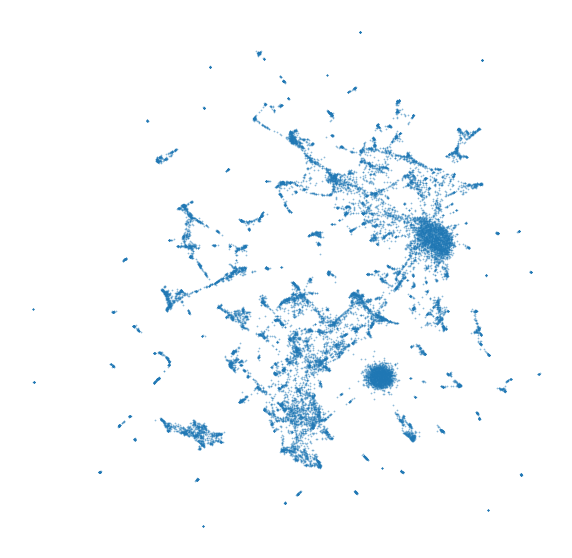

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(
    x=umap_node2vec_embedding[:, 0],
    y=umap_node2vec_embedding[:, 1],
    ax=ax,
    s=3,
    alpha=0.5,
    linewidth=0,
)
_ = ax.axis("off")

Now let's try using the Cora dataset, which is a network of academic citations.


In [53]:
edge_df = pd.read_csv("./networks-course/data/cora_nr/cora.edges")
g = nx.from_pandas_edgelist(edge_df, create_using=nx.Graph, edge_attr=None)
print(len(g.nodes))
print(len(g.edges))

2708
5278


In [54]:
node2vec_embedding, node_ids = node2vec_embed(
    g,
    dimensions=16,
    num_walks=10,
    walk_length=16,
    inout_hyperparameter=1.0,
    return_hyperparameter=1.0,
    random_seed=8888,
)

/Users/bpedigo/JHU_code/bilateral/graspologic/graspologic/utils/utils.py:1130: UserWarning: Graph has at least one unweighted edge using weight_attribute "weight". Defaulting unweighted edges to "1.0"
  warnings.warn(


In [55]:
node_ids[:10]

[1, 9, 436, 545, 4, 198, 464, 602, 5, 171]

In [56]:
nodes = pd.read_csv("networks-course/data/cora_nr/cora.node_labels", index_col=0)
nodes = nodes.reindex(node_ids)

In [57]:
umapper = UMAP(metric="cosine", min_dist=0.8, random_state=888)
umap_node2vec_embedding = umapper.fit_transform(node2vec_embedding)

In [ ]:
nodes["umap_0"] = umap_node2vec_embedding[:, 0]
nodes["umap_1"] = umap_node2vec_embedding[:, 1]
nodes["label"] = nodes["label"].astype(str)  # for seaborn

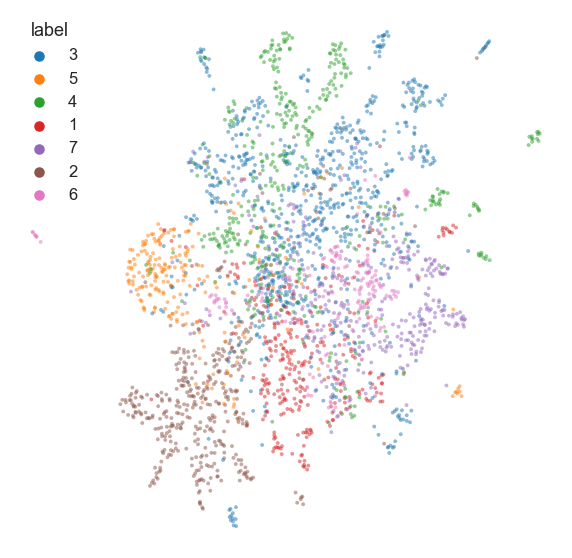

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.set_context("talk")
sns.scatterplot(
    data=nodes,
    x="umap_0",
    y="umap_1",
    ax=ax,
    hue="label",
    s=15,
    alpha=0.5,
    linewidth=0,
)
_ = ax.axis("off")

You can also use this representation to make a network layout at the same time, which
is something we often do.

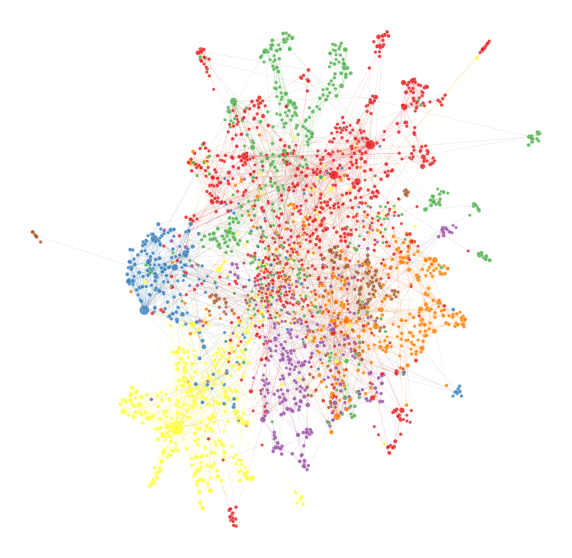

In [ ]:
adj = nx.to_scipy_sparse_matrix(g, nodelist=node_ids)

from graspologic.plot import networkplot

nodes["degree"] = np.array(np.sum(adj, axis=1))
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = networkplot(
    adj,
    x="umap_0",
    y="umap_1",
    node_data=nodes.reset_index(),
    node_hue="label",
    node_size="degree",
    node_sizes=(10, 200),
    ax=ax,
    edge_linewidth=0.2,
    edge_alpha=0.2,
)
_ = ax.axis("off")

## Applications using embeddings

### Recommendation

One common application for embeddings is recommender systems - lets say we have a network, 
and want to say something about what other nodes are most similar to a given node. Since
we have a $d$-dimensional representation which represents something about the role of 
each node in our network, we can use this to simply look up nearest neighbors in this
space. 

In [ ]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=6, metric="euclidean")
nn.fit(node2vec_embedding)

NearestNeighbors(metric='euclidean', n_neighbors=6)

In [ ]:
query_node = 0

dists, neighbor_indices = nn.kneighbors(
    node2vec_embedding[query_node, :].reshape(1, -1)
)

neighbor_indices = np.squeeze(neighbor_indices)
neighbor_indices

array([ 0,  2,  1, 29,  3, 18])

We can go back to our earlier visualization and look at the nodes which are picked as 
"most similar."

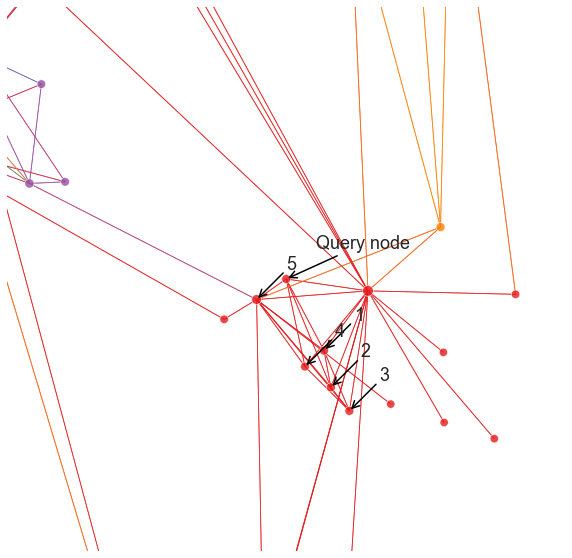

In [ ]:
ax = networkplot(
    adj,
    x="umap_0",
    y="umap_1",
    node_data=nodes.reset_index(),
    node_hue="label",
    node_size="degree",
    node_sizes=(70, 500),
    edge_linewidth=0.8,
    edge_alpha=0.8,
)
ax.axis("off")


def get_location(node_index):
    return np.array(nodes.iloc[node_index][["umap_0", "umap_1"]])


center = get_location(query_node)
pad = 0.9
ax.set(xlim=(center[0] - pad, center[0] + pad), ylim=(center[1] - pad, center[1] + pad))
_ = ax.figure.set_facecolor("w")


def annotate(node_index, text, ax):
    xy = get_location(node_index)
    ax.annotate(
        text,
        xy,
        xytext=(30, 30),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->"),
    )


annotate(query_node, "Query node", ax)

for i, node_index in enumerate(neighbor_indices[1:]):
    annotate(node_index, i + 1, ax)

<AxesSubplot:xlabel='umap_0', ylabel='umap_1'>

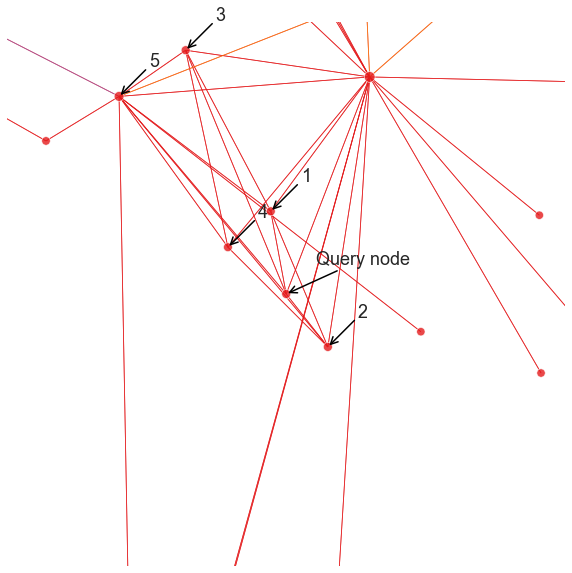

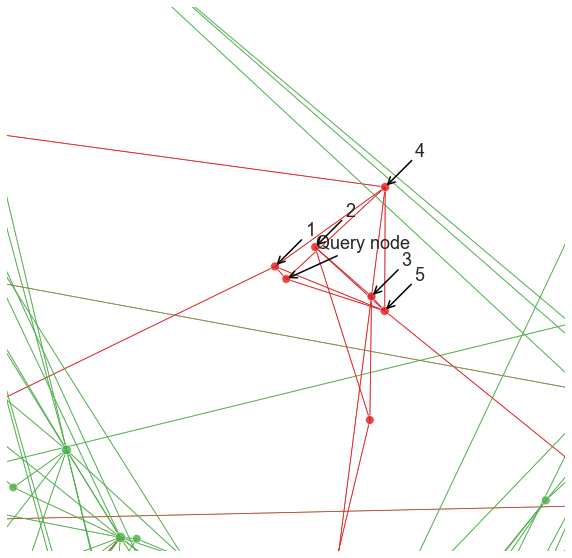

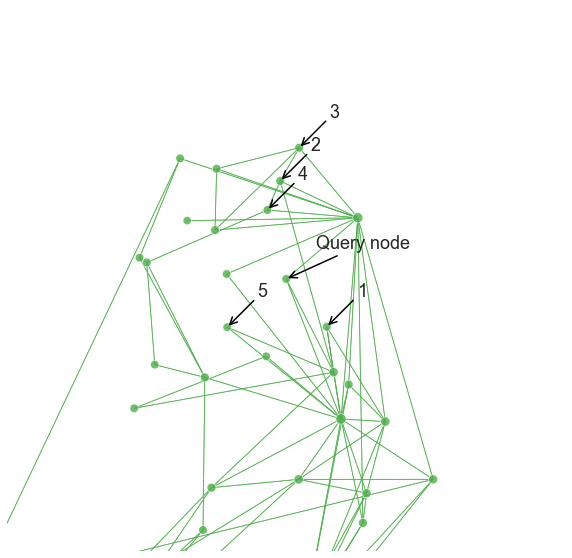

In [ ]:
def plot_neighbor_query(query_node, nn, pad=1.0):
    dists, neighbor_indices = nn.kneighbors(
        node2vec_embedding[query_node, :].reshape(1, -1)
    )

    neighbor_indices = np.squeeze(neighbor_indices)

    ax = networkplot(
        adj,
        x="umap_0",
        y="umap_1",
        node_data=nodes.reset_index(),
        node_hue="label",
        node_size="degree",
        node_sizes=(70, 500),
        edge_linewidth=0.8,
        edge_alpha=0.8,
    )
    ax.axis("off")

    center = get_location(query_node)
    ax.set(
        xlim=(center[0] - pad, center[0] + pad), ylim=(center[1] - pad, center[1] + pad)
    )
    _ = ax.figure.set_facecolor("w")

    annotate(query_node, "Query node", ax)

    for i, node_index in enumerate(neighbor_indices[1:]):
        annotate(node_index, i + 1, ax)

    return ax


nn = NearestNeighbors(n_neighbors=6, metric="euclidean")
nn.fit(node2vec_embedding)

plot_neighbor_query(1, nn, pad=0.4)
plot_neighbor_query(700, nn, pad=1.0)
plot_neighbor_query(2210, nn, pad=1.0)

```{admonition}
Why aren't the 5 closest nodes to the query in this plot always the 5 closes nodes 
computed by `NearestNeighbors`? 
```

Note that it can be difficult to interpret exactly what this recommendation is based on.
For this particular example and the Node2Vec/DeepWalk settings we were using, it looks
like we found nodes that are in the local neighborhood of the query, which is perfectly
reasonable for some applications. With other parameters though, we might get something
very different.

### Clustering

```{warning}
TODO
```

## References 
```{bibliography}
:filter: docname in docnames
:style: unsrt
```